# Green PPA Hedging

In [25]:
import datetime as dt
import sys
sys.path.insert(0,'../../../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from rivapy.tools.datetime_grid import DateTimeGrid

from rivapy.models.residual_demand_fwd_model import WindPowerForecastModel, MultiRegionWindForecastModel, LinearDemandForwardModel
from rivapy.instruments import GreenPPASpecification
from rivapy.pricing.green_ppa_pricing import GreenPPADeepHedgingPricer

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup Model for Wind and Power Prices

In [58]:
# setup 
wind_region_model = {}
vols = [1.0,3.0,6.0]
mean_reversion_speed = [0.5,2.0,6.0]
capacities = [10_000.0, 120_000.0, 75_000.0]
rnd_weights = [ [0.8,0.2],
               [0.8,0.2],
               [0.8,0.2]
              ]
np.random.seed(42)
regions = []
for i in range(len(vols)):
    model = WindPowerForecastModel(region='Region_' + str(i), 
                                            speed_of_mean_reversion=mean_reversion_speed[i],
                                            volatility=vols[i])
    regions.append(MultiRegionWindForecastModel.Region( 
                                    model,
                                    capacity=capacities[i],
                                    rnd_weights=rnd_weights[i]
                                ) )
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

In [63]:
?MultiRegionWindForecastModel

After setting up three regions we just simulate the weather forecast over the next ten days for the following four hours.

In [10]:
wind_onshore = WindPowerForecastModel(region='Onshore', speed_of_mean_reversion=0.1, volatility=4.80)
wind_offshore = WindPowerForecastModel(region='Offshore', speed_of_mean_reversion=0.5, volatility=4.80)
regions = [ MultiRegionWindForecastModel.Region( 
                                    wind_onshore,
                                    capacity=1000.0,
                                    rnd_weights=[0.8,0.2]
                                ),
           MultiRegionWindForecastModel.Region( 
                                    wind_offshore,
                                    capacity=100.0,
                                    rnd_weights=[0.2,0.8]
                                )
           
          ]
wind = MultiRegionWindForecastModel('Wind_Germany', regions)

model = LinearDemandForwardModel(wind_power_forecast=wind, 
                                    x_mean_reversion_speed= 0.1, 
                                     x_volatility=10.5,
                                    power_name= 'Power_Germany')

# Setup Green PPA Specification

In [14]:
val_date = dt.datetime(2023,1,1)
strike = 0.3 #0.22
# For illustration purposes the schedule contains just one timepoint
spec = GreenPPASpecification(udl='Power_Germany',
                            technology = 'Wind',
                             location = 'Onshore', # must be the same as the region in the wind model
                             schedule = [val_date + dt.timedelta(days=3)],
                             fixed_price=strike,
                             max_capacity = 1.0)

# PPA Hedging

In [35]:
results = {}
#with open('hedge_results.json','r') as f:
#    results = json.load(f)
from rivapy.tools.interfaces import FactoryObject

def compute_pnl_figures(pricing_results):
    pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)
    return {'mean': pnl.mean, 'var': pnl.var, '1%':np.percentile(pnl,1.0), 
            '99%': np.percentile(pnl,99.0),}

def run_hedge_experiment(val_date, ppa_spec, model, **kwargs):
    params = {}
    params['ppa_spec'] = ppa_spec.to_dict()
    params['ppa_spec_hash'] = ppa_spec.hash()
    params['model'] = model.to_dict()
    params['model_hash'] = model.hash()
    params['pricing_param'] = kwargs
    hash_key = FactoryObject.hash_for_dict(params)
    #if hash_key in results:
    pricing_result =  GreenPPADeepHedgingPricer.price(val_date, 
                                  ppa_spec, 
                                  model,**kwargs)
    #pricing_results.hedge_model.save('depp')
    # model = DeepHedgeModel.load('depp')
    return pricing_result

In [48]:
pricing_results = run_hedge_experiment(val_date, 
                                        spec, 
                                        model, 
                                        initial_forecasts={'Onshore': [0.8],
                                                    'Offshore': [0.6]},
                                        forecast_hours=[10, 14, 18],
                                        power_fwd_prices=[1.0],
                                        additional_states=['Offshore'],
                                        depth=3, nb_neurons=32, n_sims=10_000, 
                                        regularization=100.0,
                                        epochs=200, verbose=1,
                                        tensorboard_logdir = 'logs/' + dt.datetime.now().strftime("%Y%m%dT%H%M%S"), 
                                        initial_lr=5e-4,
                                        decay_steps=8_000,
                                        batch_size=100, 
                                        decay_rate=0.8, 
                                        seed=42)

Epoch 1/200
100/100 [==============================] - 17s 9ms/step - loss: -56.0748
Epoch 2/200
100/100 [==============================] - 1s 10ms/step - loss: -57.1345
Epoch 3/200
100/100 [==============================] - 1s 10ms/step - loss: -57.2935
Epoch 4/200
100/100 [==============================] - 1s 10ms/step - loss: -57.3058
Epoch 5/200
100/100 [==============================] - 1s 10ms/step - loss: -57.4609
Epoch 6/200
100/100 [==============================] - 1s 10ms/step - loss: -57.2791
Epoch 7/200
100/100 [==============================] - 1s 10ms/step - loss: -57.5345
Epoch 8/200
100/100 [==============================] - 1s 10ms/step - loss: -57.5680
Epoch 9/200
100/100 [==============================] - 1s 10ms/step - loss: -57.5070
Epoch 10/200
100/100 [==============================] - 1s 11ms/step - loss: -57.6425
Epoch 11/200
100/100 [==============================] - 1s 10ms/step - loss: -57.7022
Epoch 12/200
100/100 [==============================] - 1s 11ms

100/100 [==============================] - 1s 11ms/step - loss: -58.8327
Epoch 97/200
100/100 [==============================] - 1s 10ms/step - loss: -59.3395
Epoch 98/200
100/100 [==============================] - 1s 9ms/step - loss: -59.2071
Epoch 99/200
100/100 [==============================] - 1s 9ms/step - loss: -59.0840
Epoch 100/200
100/100 [==============================] - 1s 9ms/step - loss: -59.2641
Epoch 101/200
100/100 [==============================] - 1s 9ms/step - loss: -59.3255
Epoch 102/200
100/100 [==============================] - 1s 9ms/step - loss: -59.1076
Epoch 103/200
100/100 [==============================] - 1s 10ms/step - loss: -59.3887
Epoch 104/200
100/100 [==============================] - 1s 10ms/step - loss: -59.3459
Epoch 105/200
100/100 [==============================] - 1s 10ms/step - loss: -59.2896
Epoch 106/200
100/100 [==============================] - 1s 10ms/step - loss: -59.0486
Epoch 107/200
100/100 [==============================] - 1s 10ms/

100/100 [==============================] - 1s 9ms/step - loss: -60.4197
Epoch 191/200
100/100 [==============================] - 1s 12ms/step - loss: -60.6435
Epoch 192/200
100/100 [==============================] - 1s 11ms/step - loss: -60.4093
Epoch 193/200
100/100 [==============================] - 1s 10ms/step - loss: -60.4141
Epoch 194/200
100/100 [==============================] - 1s 9ms/step - loss: -60.5205
Epoch 195/200
100/100 [==============================] - 1s 8ms/step - loss: -60.6082
Epoch 196/200
100/100 [==============================] - 1s 8ms/step - loss: -60.6875
Epoch 197/200
100/100 [==============================] - 1s 8ms/step - loss: -60.5896
Epoch 198/200
100/100 [==============================] - 1s 9ms/step - loss: -60.4946
Epoch 199/200
100/100 [==============================] - 1s 9ms/step - loss: -60.4706
Epoch 200/200
100/100 [==============================] - 1s 8ms/step - loss: -60.8107


8/8 [==============================] - 0s 2ms/step


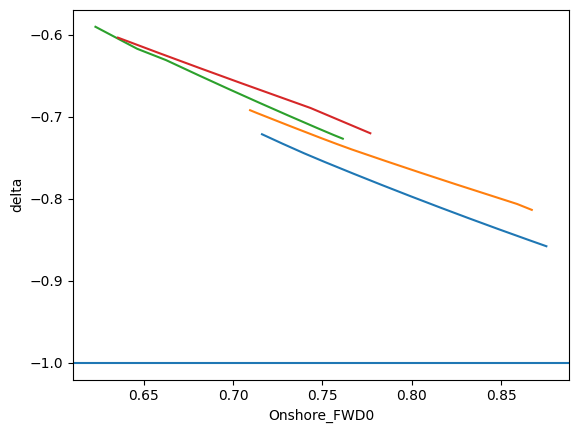

In [44]:
t = 48
p=10.0
projection = np.linspace(0.9,1.1, 250)
projected_key = 'Onshore_FWD0'
for selected in [2,5,100,400]:
#selected = 2
    #key = 'Power_Germany_FWD0'
    #x = np.percentile(pricing_results.paths[key][-1,:],p)
    #selected = np.abs(x-pricing_results.paths[key][-1,:]).argmin()
    paths = {}

    T = pricing_results.hedge_model.timegrid[-1]
    ttm = (T-pricing_results.hedge_model.timegrid[t])/T
    for k,v in pricing_results.paths.items():
        if k == projected_key:
            paths[k] = projection*v[t,selected]
            x = projection*v[t,selected]
        else:
            paths[k] = np.full(shape=(projection.shape[0]), fill_value=v[t,selected])
    delta = pricing_results.hedge_model.compute_delta(paths, ttm)   

    plt.plot(x, delta)
plt.xlabel(projected_key)
plt.axhline(-1.0)
plt.ylabel('delta');

## Hedge PnL Distribution

313/313 [==============================] - 7s 3ms/step


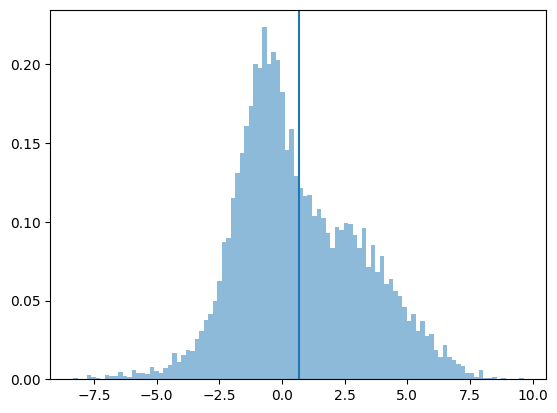

In [49]:
pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)

#plt.hist(pricing_results.payoff, bins=100, alpha=0.5, density=True)
plt.axvline(pnl.mean())
plt.hist(pnl,bins=100, alpha=0.5, density=True);

313/313 [==============================] - 3s 4ms/step


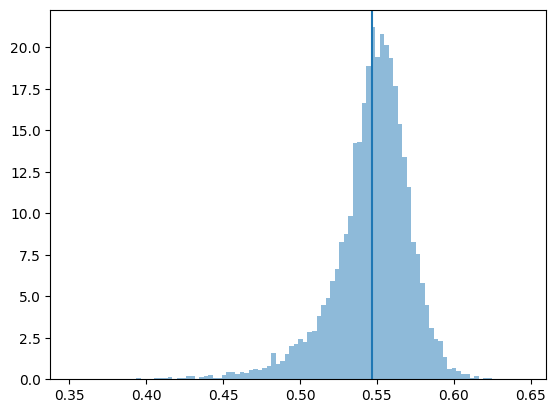

In [47]:
pnl = pricing_results.hedge_model.compute_pnl(pricing_results.paths, pricing_results.payoff)

#plt.hist(pricing_results.payoff, bins=100, alpha=0.5, density=True)
plt.axvline(pnl.mean())
plt.hist(pnl,bins=100, alpha=0.5, density=True);

## Delta vs Volume

In [57]:
pricing_results.hedge_model.compute_delta(pricing_results.paths)

313/313 [==============================] - 2s 6ms/step


array([[[ -4.96342516],
        [ -4.96342516],
        [ -4.96342516],
        ...,
        [ -4.96342516],
        [ -4.96342516],
        [ -4.96342516]],

       [[ -4.9541502 ],
        [ -4.93505478],
        [ -4.96750641],
        ...,
        [ -4.94349718],
        [ -4.9708209 ],
        [ -4.9377141 ]],

       [[ -4.94514942],
        [ -4.93932056],
        [ -4.97665215],
        ...,
        [ -4.89261341],
        [ -4.98755884],
        [ -4.91135311]],

       ...,

       [[-30.4707756 ],
        [-20.53898621],
        [-17.6346302 ],
        ...,
        [-25.44033623],
        [-10.54989147],
        [-25.69465256]],

       [[-31.26119041],
        [-20.7964592 ],
        [-21.15811348],
        ...,
        [-26.18714333],
        [-11.7241621 ],
        [-25.53804398]],

       [[-31.61169815],
        [-20.44512558],
        [-27.17195511],
        ...,
        [-27.64533424],
        [ -6.50994349],
        [-25.93655777]]])

In [53]:
pricing_results.paths['Power_Germany_FWD0'].shape

(73, 10000)

## Path Plots

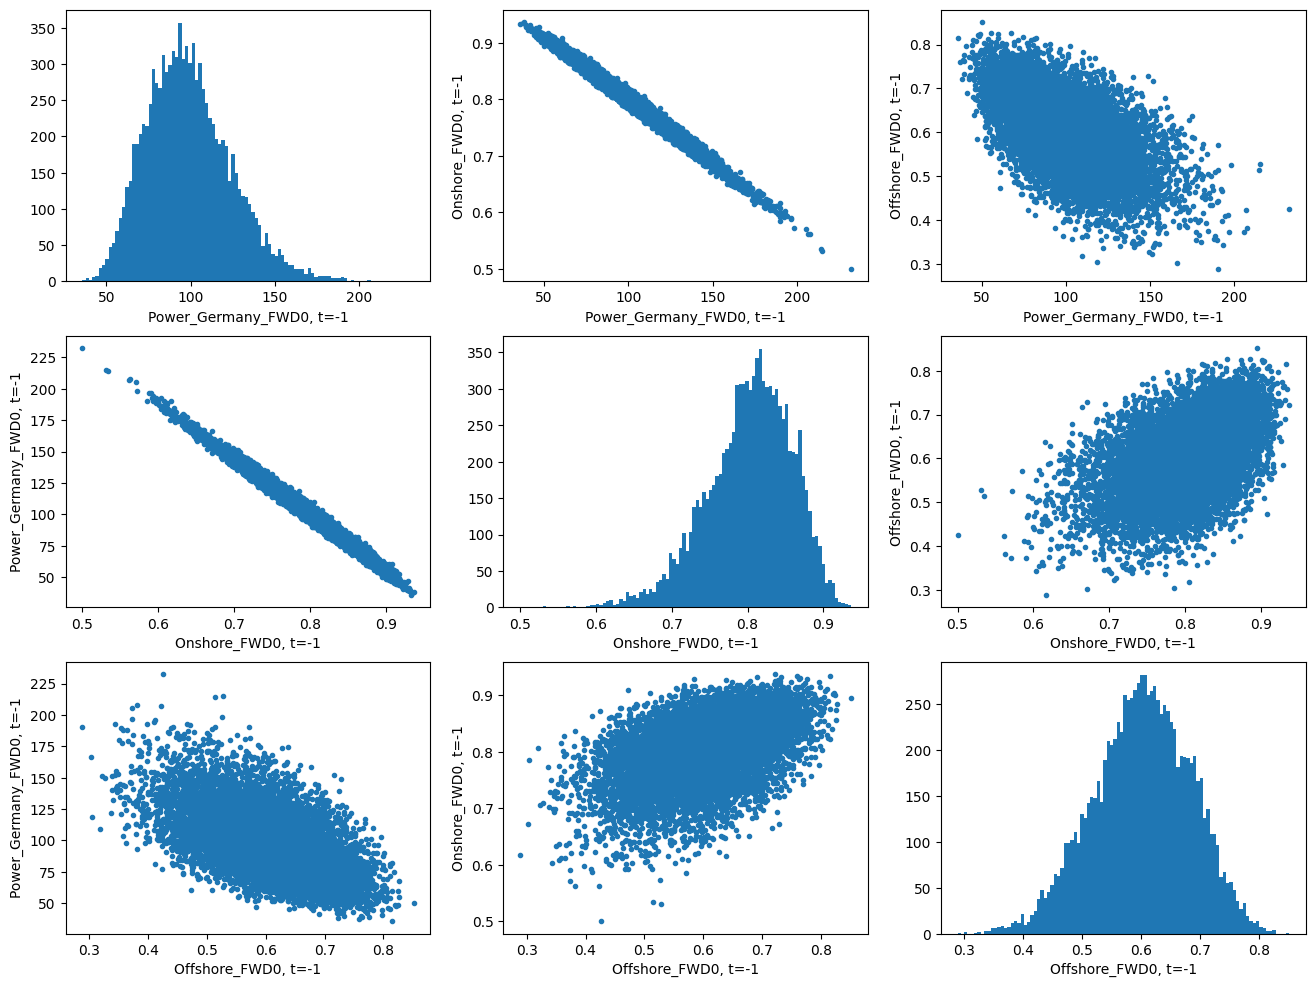

In [42]:
t = -1
plt.figure(figsize=(16,12))
n_x = 3
n_y = 3
i=1
for k,v in pricing_results.paths.items():
    for l,w in pricing_results.paths.items():
        plt.subplot(n_x,n_y,i)
        if k==l:
            plt.hist(v[t,:], bins=100)
            plt.xlabel(k+', t='+str(t))
        else:
            plt.plot(v[t,:], w[t,:], '.')
            plt.xlabel(k+', t='+str(t))
            plt.ylabel(l+', t='+str(t))
        i += 1

## Delta Plots

313/313 [==============================] - 1s 2ms/step


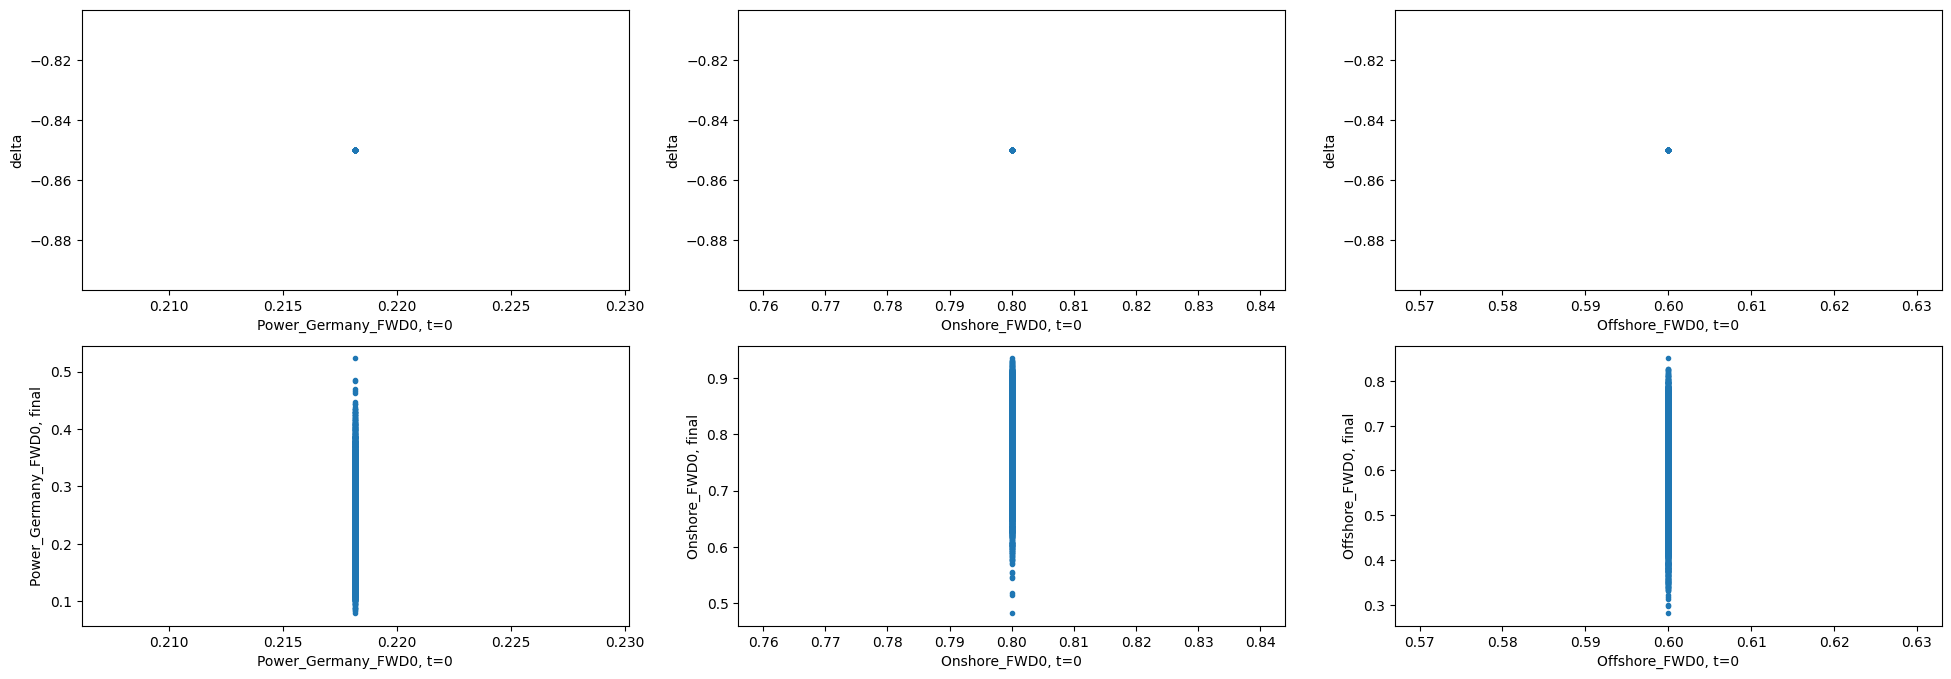

In [64]:
t = 0
n_x = 2
n_y = 3
plt.figure(figsize=(24,8))
delta = pricing_results.hedge_model.compute_delta(pricing_results.paths, t)
i=1
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], delta,'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel('delta')
    i+= 1
    
for k,v in pricing_results.paths.items():
    plt.subplot(n_x, n_y, i)
    plt.plot(v[t,:], v[-1,:],'.')
    plt.xlabel(k+', t='+str(t))
    plt.ylabel(k+', final')
    i+= 1